<a href="https://colab.research.google.com/github/TradeForce-AI/HMMs_Stock_Market/blob/main/Multivariate_Multi_Step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf
import yfinance as yf

# from google.colab import drive
# drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [78]:
## Calculate the Savitzky-Golay filter
from scipy.signal import savgol_filter

def sgf(data,window=501,order=5):
  x = data.index
  y = data
  yhat = savgol_filter(y, window, order) # window size 51, polynomial order 3
  return yhat

  
# Fast Fourier Transform
# def fftrsm(data,threshold=2e4):
#   s = data
#   fourier = rfft(s)
#   frequencies = rfftfreq(s.size, d=2e-3 / s.size)
#   display(1/frequencies)
#   fourier[frequencies > threshold] = 0
#   return irfft(fourier)

In [79]:
def prep_data(df):
# Create the Next day open column(Optional - to test)
  df['Next_Open'] = df['Open'].shift(periods=-1)
  # Create the target label
  df['Target'] = df['Close'].shift(periods=-1)
  # Calculate the bands squeeze of the Close to monitor the volatility
  window_size = 2
  num_of_std = 2.0
      
  rolling_mean = df['Close'].rolling(window=window_size).mean()
  rolling_std  = df['Close'].rolling(window=window_size).std()
  upper_band = rolling_mean + (rolling_std*num_of_std)
  lower_band = rolling_mean - (rolling_std*num_of_std)
  df['C_Squeeze'] = upper_band - lower_band

  # Calculate the ATR

  high_low = df['High'] - df['Low']
  high_close = np.abs(df['High'] - df['Close'].shift())
  low_close = np.abs(df['Low'] - df['Close'].shift())

  ranges = pd.concat([high_low, high_close, low_close], axis=1)
  true_range = np.max(ranges, axis=1)

  df['Atr'] = true_range.rolling(14).sum()/14

  # Calculate the Savitzky-Golay filter of the Adj Close

  df['SGF_Slow'] = sgf(df['Close'],501,5) 
  df['SGF_Fast'] = sgf(df['Close'],51,3)

  df.dropna(inplace=True)

  # Remove no necessary columns
  df.drop('Adj Close', axis = 1, inplace= True)

  return df

In [80]:
instrument = 'ES=F'
start_date = '2005-01-01'
end_date = '2021-01-01'
prd= '1d'

In [81]:
df = yf.download(instrument, start=start_date, end=end_date, period=prd)

# Collect data for train and testing
dt = prep_data(df)
dataset = dt[:3019]
dataset_forward = dt[3020:]
dataset.info()
dataset_forward.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2005-01-21 to 2017-01-10
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3019 non-null   float64
 1   High       3019 non-null   float64
 2   Low        3019 non-null   float64
 3   Close      3019 non-null   float64
 4   Volume     3019 non-null   int64  
 5   Next_Open  3019 non-null   float64
 6   Target     3019 non-null   float64
 7   C_Squeeze  3019 non-null   float64
 8   Atr        3019 non-null   float64
 9   SGF_Slow   3019 non-null   float64
 10  SGF_Fast   3019 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 283.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999 entries, 2017-01-12 to 2020-12-30
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       999 non-null 

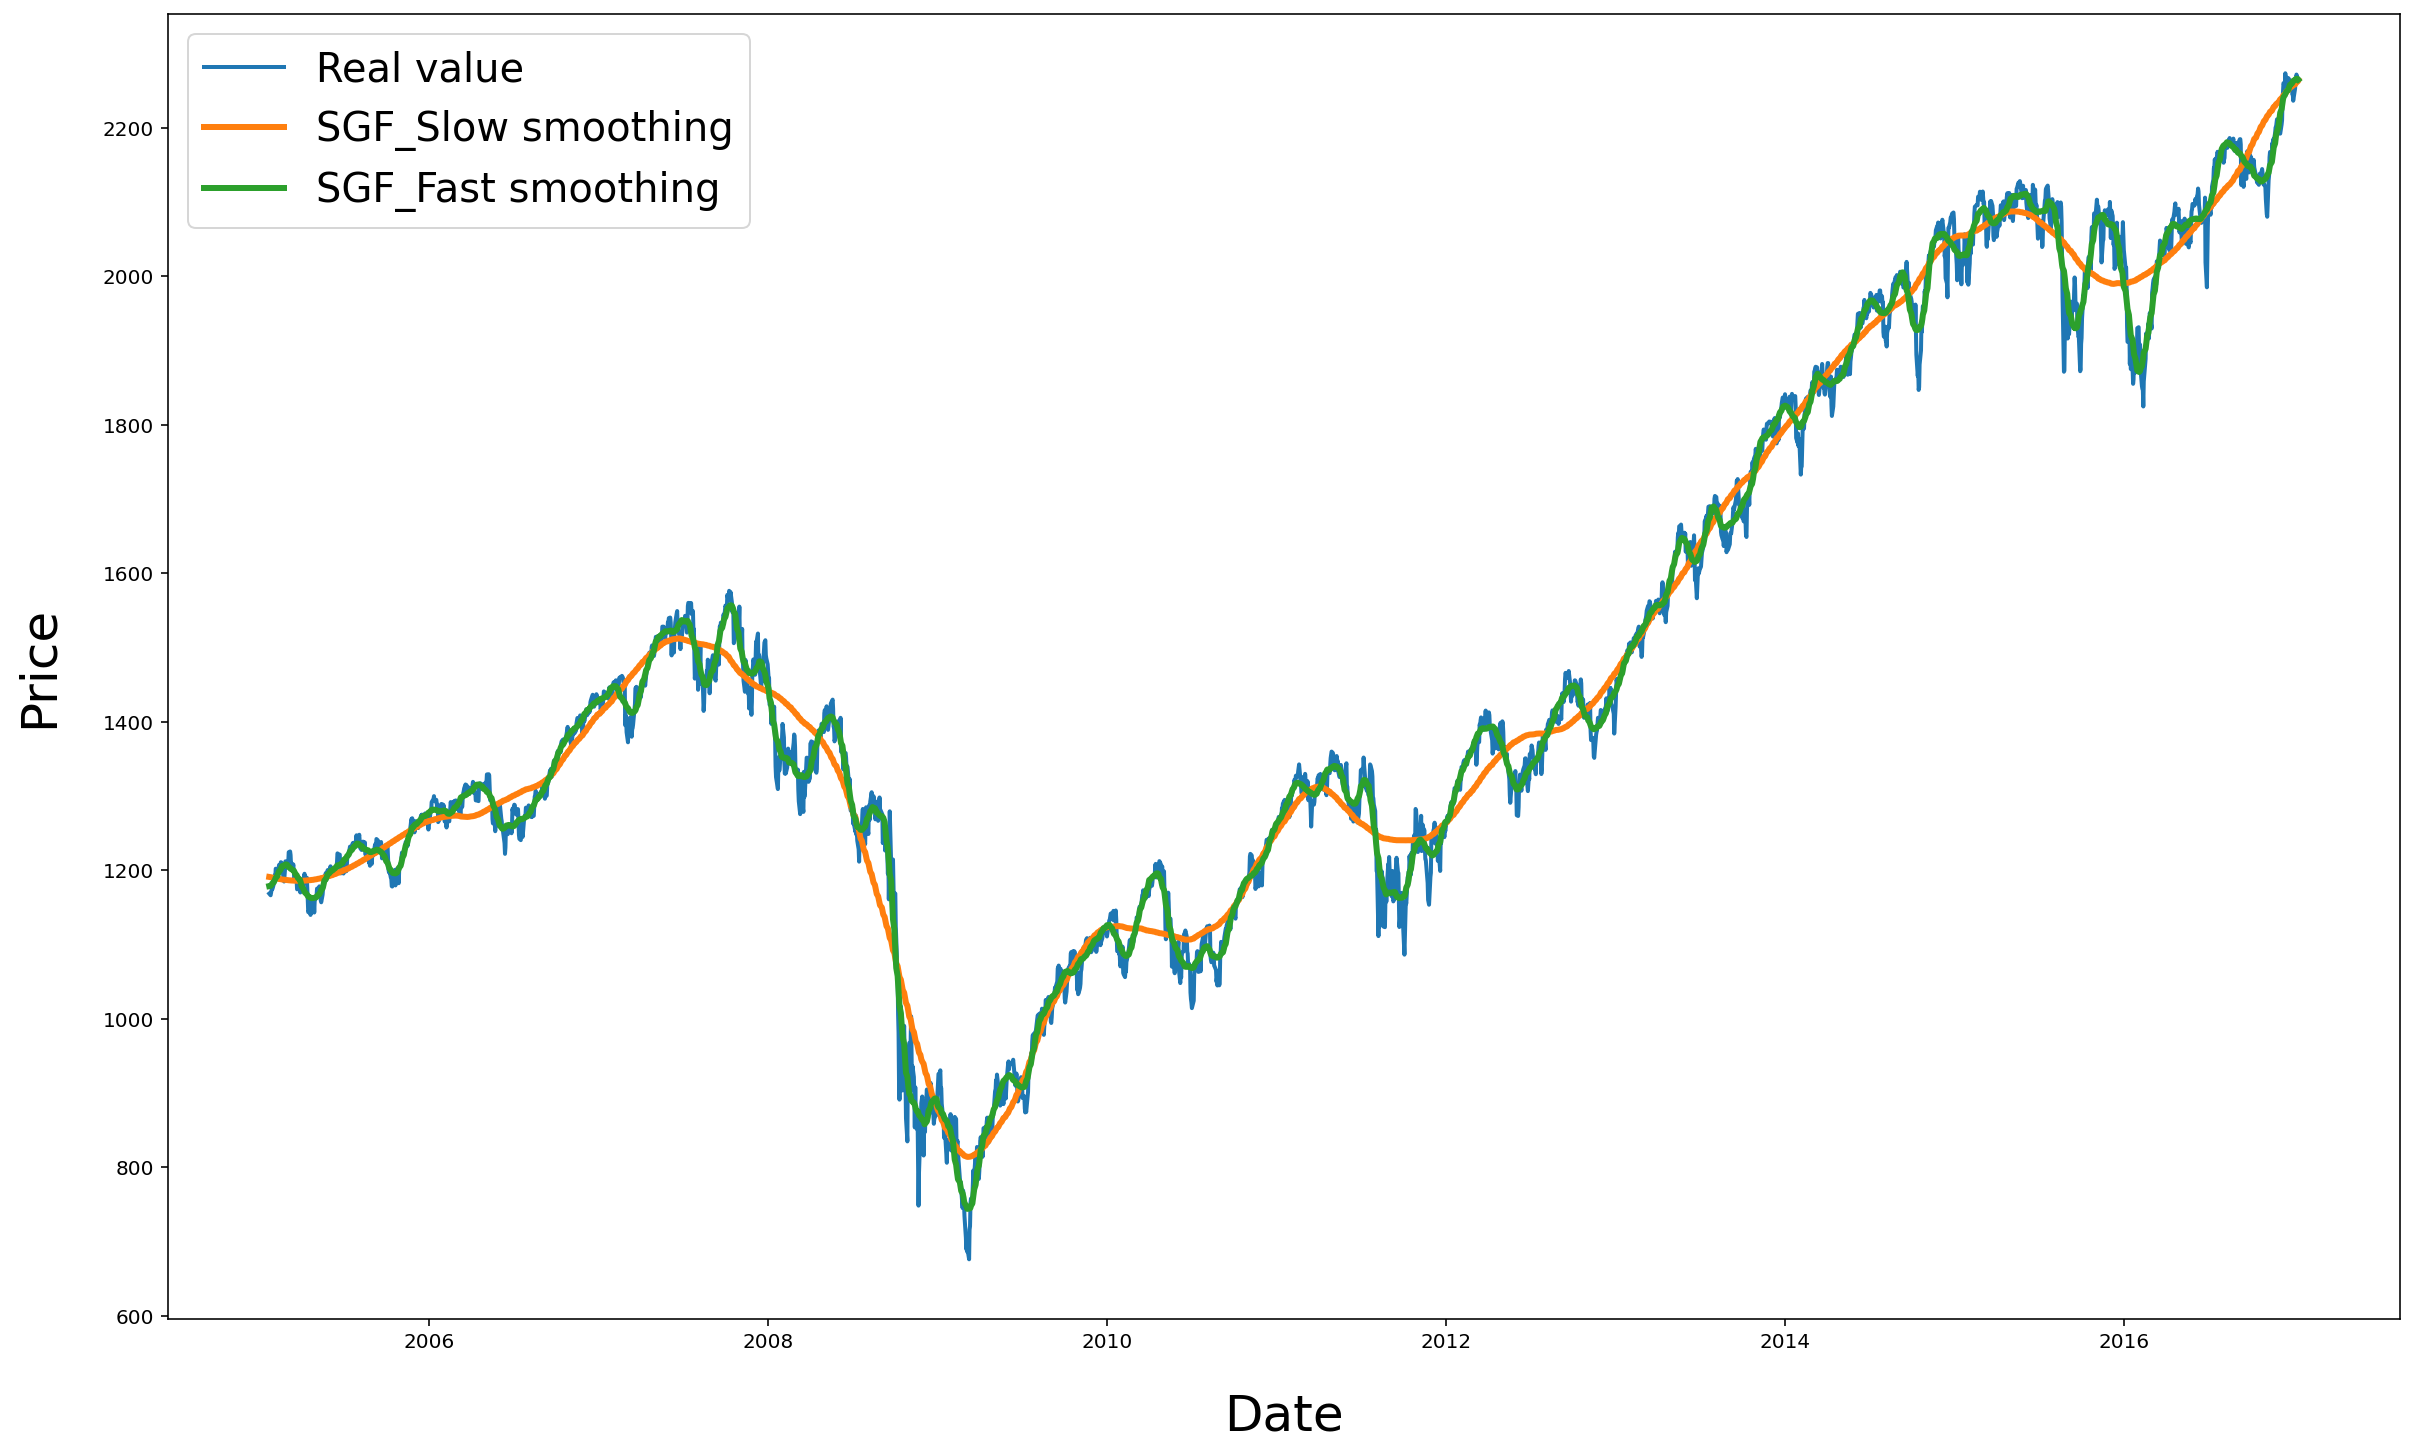

In [82]:
fig = plt.figure(figsize=(20,12))
plt.xlabel('Date',fontsize=25, labelpad=20)
plt.ylabel('Price',fontsize=25, labelpad=20)
plt.plot(dataset['Close'], linewidth=2)
plt.plot(dataset['SGF_Slow'], linewidth=3)
plt.plot(dataset['SGF_Fast'], linewidth=3)
plt.legend(['Real value','SGF_Slow smoothing','SGF_Fast smoothing'], prop={'size': 20})
plt.title('',fontsize=25, pad=20)
                                                 
plt.show()

In [83]:
dataset.tail()

,Open,High,Low,Close,Volume,Next_Open,Target,C_Squeeze,Atr,SGF_Slow,SGF_Fast
Date,,,,,,,,,,,
2017-01-04,2252.75,2267.25,2251.00,2264.25,1404875,2264.50,2264.25,33.234019,15.500000,2259.101639,2265.203504
2017-01-05,2264.50,2266.00,2254.00,2264.25,1324035,2264.25,2271.50,0.000000,14.285714,2260.009816,2265.653724
2017-01-06,2264.25,2277.00,2258.25,2271.50,1551007,2271.25,2265.00,20.506097,14.160714,2261.031069,2265.797810
2017-01-09,2271.25,2275.25,2263.50,2265.00,1025182,2264.50,2263.75,18.384776,14.446429,2262.295531,2265.517265
2017-01-10,2264.50,2274.00,2259.50,2263.75,1304523,2263.75,2270.50,3.535534,14.517857,2263.637404,2264.684013


In [84]:
x_1 = dataset['Open']
x_2 = dataset['High']
x_3 = dataset['Low']
x_4 = dataset['Close']
x_5 = dataset['Volume']
x_6 = dataset['Next_Open']
x_7 = dataset['C_Squeeze']
x_8 = dataset['Atr']
x_9 = dataset['SGF_Slow']
x_10 = dataset['SGF_Fast']
y = dataset['Target']

x_1 = x_1.values
x_2 = x_2.values
x_3 = x_3.values
x_4 = x_4.values
x_5 = x_5.values
x_6 = x_6.values
x_7 = x_7.values
x_8 = x_8.values
x_9 = x_9.values
x_10 = x_10.values
y = y.values

In [85]:
# convert to [rows, columns] structure
x_1 = x_1.reshape((len(x_1), 1))
x_2 = x_2.reshape((len(x_2), 1))
x_3 = x_3.reshape((len(x_3), 1))
x_4 = x_4.reshape((len(x_4), 1))
x_5 = x_5.reshape((len(x_5), 1))
x_6 = x_6.reshape((len(x_6), 1))
x_7 = x_7.reshape((len(x_7), 1))
x_8 = x_8.reshape((len(x_8), 1))
x_9 = x_9.reshape((len(x_9), 1))
x_10 = x_10.reshape((len(x_10), 1))
y = y.reshape((len(y), 1))

# print ("x_1.shape" , x_1.shape) 
# print ("x_2.shape" , x_2.shape) 
# print ("y.shape" , y.shape) 

In [86]:
# normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
x_1_scaled = scaler.fit_transform(x_1)
x_2_scaled = scaler.fit_transform(x_2)
x_3_scaled = scaler.fit_transform(x_3)
x_4_scaled = scaler.fit_transform(x_4)
x_5_scaled = scaler.fit_transform(x_5)
x_6_scaled = scaler.fit_transform(x_6)
x_7_scaled = scaler.fit_transform(x_7)
x_8_scaled = scaler.fit_transform(x_8)
x_9_scaled = scaler.fit_transform(x_9)
x_10_scaled = scaler.fit_transform(x_10)
y_scaled = scaler.fit_transform(y)

# horizontally stack columns
dataset_stacked = hstack((x_1_scaled, x_2_scaled, x_3_scaled, x_4_scaled, x_5_scaled, x_6_scaled, x_7_scaled, x_8_scaled, x_9_scaled, x_10_scaled, y_scaled))

print ("dataset_stacked.shape" , dataset_stacked.shape) 

dataset_stacked.shape (3019, 11)


In [87]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [88]:
# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 45 , 5 

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)

print ("X.shape" , X.shape) 
print ("y.shape" , y.shape) 

X.shape (2971, 45, 10)
y.shape (2971, 5)


In [89]:
split = 1258*25
train_X , train_y = X[:split, :] , y[:split, :]
test_X , test_y = X[split:, :] , y[split:, :]

n_features = train_X.shape[2]


In [90]:
print ("train_X.shape" , train_X.shape) 
print ("train_y.shape" , train_y.shape) 
print ("test_X.shape" , test_X.shape) 
print ("test_y.shape" , test_y.shape) 
print ("n_features" , n_features)

train_X.shape (2971, 45, 10)
train_y.shape (2971, 5)
test_X.shape (0, 45, 10)
test_y.shape (0, 5)
n_features 10


**LSTM Model Parameter Setting**

In [91]:
#optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=0.01)

# define model
model = Sequential()
model.add(LSTM(120, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(Activation('linear'))
model.compile(loss='mse' , optimizer=opt , metrics=['mse'])


In [92]:
# Fit network
history = model.fit(train_X , train_y , epochs=120 , steps_per_epoch=25 , verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)


Epoch 1/120
25/25 [==============================] - 9s 194ms/step - loss: 92065660928.0000 - mse: 92065669120.0000
Epoch 2/120
25/25 [==============================] - 5s 203ms/step - loss: 326.5034 - mse: 326.5034
Epoch 3/120
25/25 [==============================] - 5s 186ms/step - loss: 65.4015 - mse: 65.4015
Epoch 4/120
25/25 [==============================] - 5s 206ms/step - loss: 0.0408 - mse: 0.0408
Epoch 5/120
25/25 [==============================] - 5s 202ms/step - loss: 0.0634 - mse: 0.0634
Epoch 6/120
25/25 [==============================] - 5s 198ms/step - loss: 0.0703 - mse: 0.0703
Epoch 7/120
25/25 [==============================] - 5s 200ms/step - loss: 0.0213 - mse: 0.0213
Epoch 8/120
25/25 [==============================] - 5s 199ms/step - loss: 0.0541 - mse: 0.0541
Epoch 9/120
25/25 [==============================] - 5s 187ms/step - loss: 0.0146 - mse: 0.0146
Epoch 10/120
25/25 [==============================] - 5s 193ms/step - loss: 0.0212 - mse: 0.0212
Epoch 11/120


Evaluation



In [93]:
# Test Dataset Forward
dataset_forward.tail()

,Open,High,Low,Close,Volume,Next_Open,Target,C_Squeeze,Atr,SGF_Slow,SGF_Fast
Date,,,,,,,,,,,
2020-12-23,3674.25,3701.75,3651.0,3681.50,1021819,3685.25,3695.00,12.020815,46.196429,3702.763880,3714.853719
2020-12-24,3685.25,3696.00,3678.5,3695.00,369650,3682.00,3727.50,38.183766,44.910714,3706.435521,3712.095037
2020-12-28,3682.00,3732.25,3676.0,3727.50,760654,3731.00,3720.00,91.923882,46.589286,3710.013339,3708.262752
2020-12-29,3731.00,3747.75,3714.5,3720.00,992636,3724.50,3724.25,21.213203,45.839286,3713.494830,3703.317492
2020-12-30,3724.50,3738.25,3716.5,3724.25,769995,3725.00,3748.75,12.020815,43.446429,3716.877462,3697.219885


In [94]:
# read test data
x1_test = dataset_forward['Open'].values
x2_test = dataset_forward['High'].values
x3_test = dataset_forward['Low'].values
x4_test = dataset_forward['Close'].values
x5_test = dataset_forward['Volume'].values
x6_test = dataset_forward['Next_Open'].values
x7_test = dataset_forward['C_Squeeze'].values
x8_test = dataset_forward['Atr'].values
x9_test = dataset_forward['SGF_Slow'].values
x10_test = dataset_forward['SGF_Fast'].values
y_test = dataset_forward['Target'].values # no need to scale

# convert to [rows, columns] structure
x1_test = x1_test.reshape((len(x1_test), 1))
x2_test = x2_test.reshape((len(x2_test), 1))
x3_test = x3_test.reshape((len(x3_test), 1))
x4_test = x4_test.reshape((len(x4_test), 1))
x5_test = x5_test.reshape((len(x5_test), 1))
x6_test = x6_test.reshape((len(x6_test), 1))
x7_test = x7_test.reshape((len(x7_test), 1))
x8_test = x8_test.reshape((len(x8_test), 1))
x9_test = x9_test.reshape((len(x9_test), 1))
x10_test = x10_test.reshape((len(x10_test), 1))
y_test = y_test.reshape((len(y_test), 1))

x1_test_scaled = scaler.fit_transform(x1_test)
x2_test_scaled = scaler.fit_transform(x2_test)
x3_test_scaled = scaler.fit_transform(x3_test)
x4_test_scaled = scaler.fit_transform(x4_test)
x5_test_scaled = scaler.fit_transform(x5_test)
x6_test_scaled = scaler.fit_transform(x6_test)
x7_test_scaled = scaler.fit_transform(x7_test)
x8_test_scaled = scaler.fit_transform(x8_test)
x9_test_scaled = scaler.fit_transform(x9_test)
x10_test_scaled = scaler.fit_transform(x10_test)


In [95]:
def prep_data(x1_test_scaled , x2_test_scaled , x3_test_scaled, x4_test_scaled, x5_test_scaled, x6_test_scaled, x7_test_scaled, x8_test_scaled, x9_test_scaled, x10_test_scaled, y_test , start , end , last):
    #prepare test data X
    dataset_test = hstack((x1_test_scaled , x2_test_scaled , x3_test_scaled, x4_test_scaled, x5_test_scaled, x6_test_scaled, x7_test_scaled, x8_test_scaled, x9_test_scaled, x10_test_scaled))
    dataset_test_X = dataset_test[start:end, :]
    test_X_new = dataset_test_X.reshape(1, dataset_test_X.shape[0] , dataset_test_X.shape[1])

    #prepare past and groundtruth
    past_data = y_test[:end , :]
    dataset_test_y = y_test[end:last , :]
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    scaler1.fit(dataset_test_y)

    # predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = scaler1.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]
    
    return y_pred_inv , dataset_test_y , past_data

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('')
    print('')

# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    
    plt.figure(figsize=(20, 4))

    y_mean = mean(prediction1)

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')

    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [96]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
    plt.legend(loc='upper left')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

Test Data from 120 to 165
Mean Absolute Error: 6.14
Root Mean Square Error: 6.58


Test Data from 180 to 225
Mean Absolute Error: 11.67
Root Mean Square Error: 14.03




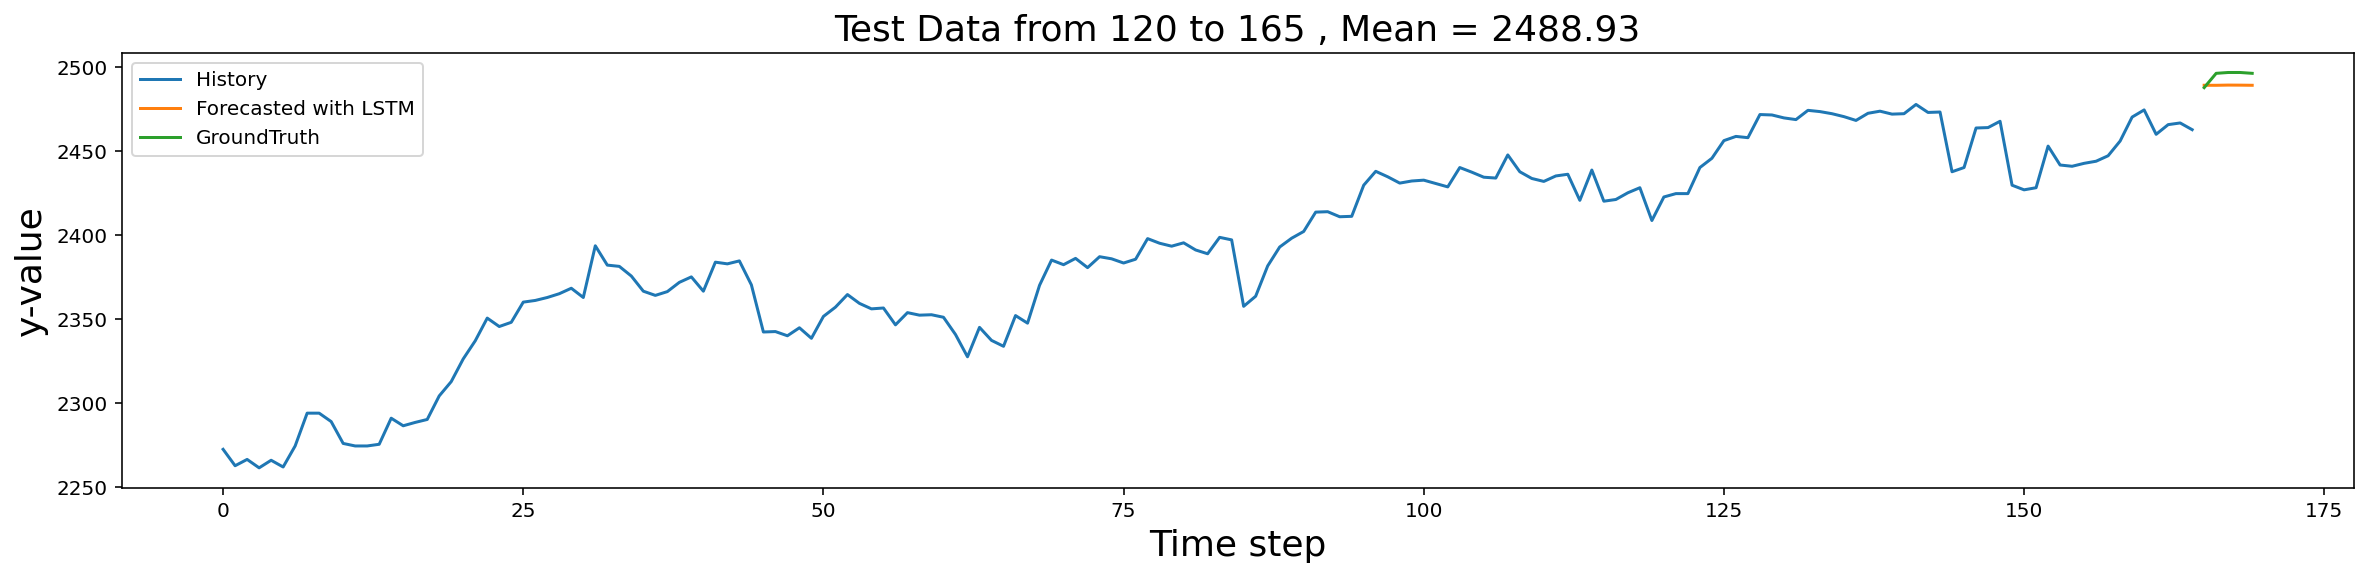

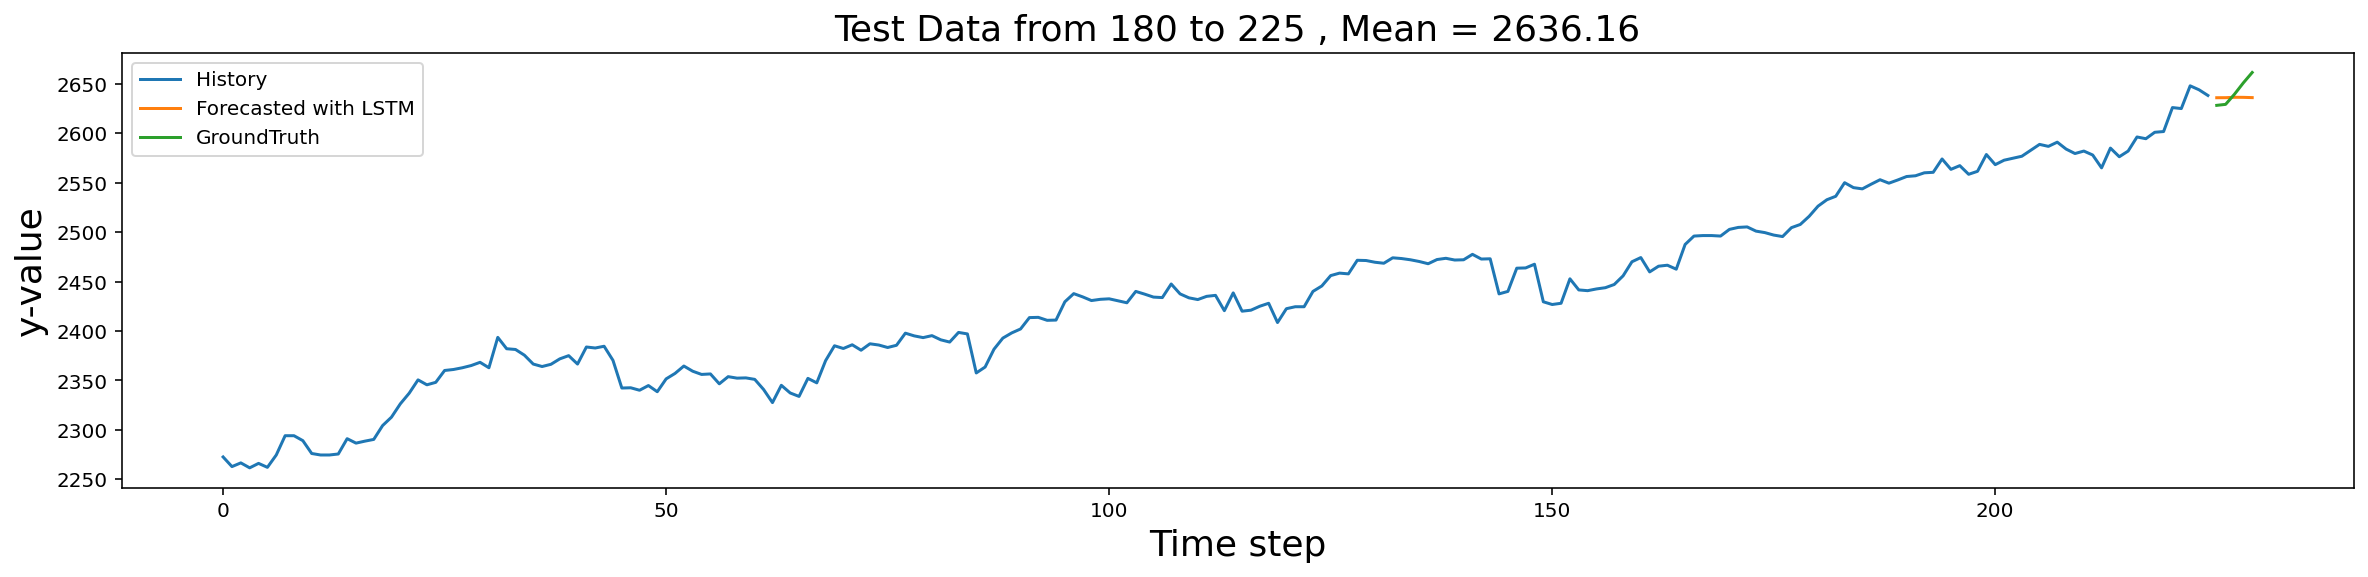

In [97]:
for i in range(120,240,60):
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , x3_test_scaled , x4_test_scaled, x5_test_scaled , x6_test_scaled, x7_test_scaled , x8_test_scaled, x9_test_scaled , x10_test_scaled, y_test , start , end , last) 
    evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end) 
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end) 


Save & Load


In [ ]:
# model_url = '/Directory/Filename.h5'
# model.save(model_url)
# print("Saved")

In [ ]:
# model_url = '/Directory/Filename.h5'
# model = load_model(model_url)
# print("Loaded")
# model.summary()